In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.svm import SVC ## support vectore classifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import pickle
import os
import csv
import logging
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler

In [2]:
class Human_activity_recognition_svc(object):
    def __init__(self,dir_path):
        self.dir_path = dir_path
        logging.basicConfig(filename='svc.log', level=logging.DEBUG,
                    format='%(asctime)s:%(levelname)s:%(message)s')
        logging.info('Human_activity_recognition_svc class object is created.')
        
    def prepare_datset(self):
        """
        Create a final csv-'merge.csv'from the directory folder to be used as dataframe for later stage.
        
        
        Parameters
        ----------
        None
        
        Returns:
        ----------
        None        
        """   
        logging.info('Dataset preparation started from the raw data.') 
        try:
            # assign directory
            directory = self.dir_path

            # iterate over files in
            # that directory
            folder_file_dict = {}
            for filename in os.listdir(directory):
                f = os.path.join(directory, filename)
                # checking if it is not a file
                if not os.path.isfile(f):
                    file_list = [os.path.join(f, sub_filename) for sub_filename in os.listdir(f) if sub_filename != "README.txt"]
                    folder_file_dict[filename] = file_list      
            header = []
            df_list = []
            for key in folder_file_dict:
                for file in folder_file_dict[key]:
                    with open(file, "r", encoding="shift_jis", errors="", newline="" ) as f:
                        lst = csv.reader(f, delimiter=",")
                        df = pd.DataFrame(lst)
                        df.drop(df.columns[[0,4,5,6,7]], axis=1, inplace =True)
                        df_list.append(df)
                merged_df = pd.concat(df_list)
                merged_df.columns = ["frontal_axis_reading(g)","vertical_axis_reading(g)","lateral_axis_reading(g)","activity"]
                merged_df.to_csv('merged.csv', index=None, header=True)
        except Exception as e:
            logging.error("{} occured while creating datasets from the raw data.".format(str(e)))               
            
    def load_dataset(self):
        """
        Load csv file as pandas dataframe.
        
        
        Parameters
        ----------
        None
        
        Returns:
        ----------
        None        
        """
        logging.info('Dataset is getting loaded as pandas dataframe.')
        try:        
            self.df = pd.read_csv("merged.csv") 
            self.df.drop(['time','Unnamed: 8'], axis=1, inplace=True)
        except FileNotFoundError:
            logging.error("File not found: exception occured while loading csv as pandas dataframe.")
        except pd.errors.EmptyDataError:
            logging.error("No data: exception occured while loading csv as pandas dataframe.")
        except pd.errors.ParserError:
            logging.errornt("Parse error: exception occured while loading csv as pandas dataframe.")
        except Exception as e:
            logging.error("{} occured while loading csv as pandas dataframe.".format(str(e)))
            
    def create_profile_report(self,inp_df):
        """
        Create pandas profile report for the input data frame.
        
        
        Parameters
        ----------
        inp_df: Input data frame.
        
        Returns:
        ----------
        None        
        """    
        logging.info('Profile reporting started for dataframe.')
        return ProfileReport(inp_df)
    
    def handle_outlier(self):
        """
        remove outliers for the impacted feature columns.


        Parameters
        ----------
        None

        Returns:
        ----------
        None        
        """
        logging.info('Outliers are getting removed.')
        q = self.df['lateral_axis_reading(g)'].quantile(.90)
        self.df_new = self.df[self.df['lateral_axis_reading(g)'] < q]
        
    def standard_scaling(self):
        """
        Perform standard scaling on input dataframe.
        
        
        Parameters
        ----------
        None
        
        Returns:
        ----------
        None        
        """      
        logging.info('Standard scalling started for feature columsn.')
        self.y = self.df_new['activity']
        self.x = self.df_new.drop(columns=['activity'])
        scalar = StandardScaler()
        self.x_scaled = scalar.fit_transform(self.x)
        self.df_new_scalar = pd.DataFrame(scalar.fit_transform(self.df_new))
        
    def train_test_split(self, test_size, random_state):
        """
        Split data frame into train and test.
         
        Parameters
        ----------
        None
        
        Returns:
        ----------
        Train and test data for feature and predicted columns.        
        """
        logging.info('train and test split for dataframe started.')
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x_scaled , self.y , test_size = test_size , random_state = random_state)
        
    def hyperparam_tuning_fit(self):
        # defining parameter range
        param = {'C': [0.1, 1, 10, 100, 1000],
                      'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                      'kernel': ['linear', 'poly', 'rbf', 'sigmoid' ]}    

        self.grid = GridSearchCV(SVC(), param_grid = param, refit = True, verbose = 3)       
        
        # fitting the model for grid search
        self.svm_model = self.grid.fit(self.x_train, self.y_train)

        # print best parameter after tuning
        print(self.grid.best_params_)

        # print how our model looks after hyper-parameter tuning
        print(self.grid.best_estimator_)
        
    def calc_classification_score(self):
        """
        Calculate the classification score.
        
        Parameters
        ----------
        None. 
        
        Returns:
        ----------
        None. 
        """        
        grid_predictions = self.grid.predict(self.x_test)

        # print classification report
        print(classification_report(self.y_test, grid_predictions)) 

        
    def predict(self,test_case):
        """
        Predict the dependent feature based on the input test case.
        
        Parameters
        ----------
        test_case: It is the independent variable list value. 
        
        Returns:
        ----------
        Returns the predicted feature. 
        """               
        logging.info('Prediction will be done for the testcase {}.'.format(test_case))
        try:
            return self.grid.predict(test_case)
        except Exception as e:
            logging.error("{} occured while predicting dependent feature.".format(str(e)))
            return None
        
    def save_svc_model(self,file_name):
        """
        Save the svc model based on the input file name.
        
        Parameters
        ----------
        file_name: svc model will be saved with this file name. 
        
        Returns:
        ----------
        None. 
        """  
        logging.info('Save svm model into file: {}.'.format(file_name))
        try:
            pickle.dump(self.svm_model,open(file_name,'wb'))
        except Exception as e:
            logging.error("{} occured while saving svm model.".format(str(e)))        

In [3]:
svc_obj = Human_activity_recognition_svc('../Datasets_Healthy_Older_People')

In [4]:
svc_obj.prepare_datset()

In [5]:
svc_obj.load_dataset()

In [6]:
inp_df = svc_obj.df
pf = svc_obj.create_profile_report(inp_df)
pf.to_widgets()
pf.to_file("har_profiling.html")

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

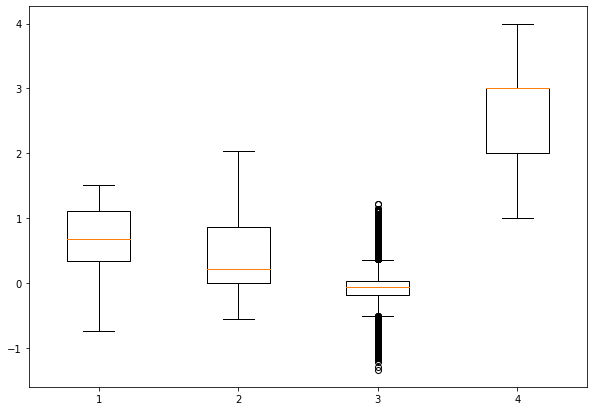

In [7]:
fig = pyplot.figure(figsize =(10, 7))
 
# Creating plot
pyplot.boxplot(inp_df)
 
# show plot
pyplot.show()

In [8]:
svc_obj.handle_outlier()

In [9]:
svc_obj.standard_scaling()

In [10]:
svc_obj.train_test_split(0.2,144)

In [11]:
svc_obj.hyperparam_tuning_fit()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ........C=100, gamma=1, kernel=rbf;, score=0.940 total time=  53.0s
[CV 2/5] END ........C=100, gamma=1, kernel=rbf;, score=0.940 total time=  54.2s
[CV 3/5] END ........C=100, gamma=1, kernel=rbf;, score=0.942 total time= 1.2min
[CV 4/5] END ........C=100, gamma=1, kernel=rbf;, score=0.939 total time=  56.6s
[CV 5/5] END ........C=100, gamma=1, kernel=rbf;, score=0.939 total time=  55.5s
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=100, gamma=1)


In [12]:
svc_obj.calc_classification_score()

              precision    recall  f1-score   support

           1       0.80      0.95      0.87      2637
           2       0.75      0.41      0.53       691
           3       1.00      1.00      1.00      9809
           4       0.70      0.33      0.45       382

    accuracy                           0.94     13519
   macro avg       0.81      0.67      0.71     13519
weighted avg       0.94      0.94      0.93     13519



In [14]:
testcase = [svc_obj.x_test[0]]
print(testcase)
print(svc_obj.predict(testcase))

[array([-0.47399757,  1.41783671,  0.83561075])]
[1]


In [15]:
svc_obj.save_svc_model('svc_model')